In [4]:
############################
# IMPORTACION DE LIBRERIAS #
############################

import numpy as np
import pandas as pd
import warnings
import collections
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor



In [19]:
###############################################
# FUNCIONES PARA PREPROCESADO Y VISUALIZACION #
###############################################

#RANGO INTERCUARTILICO
def iqr_calculate(column):
    description = column.describe()
    iqr = description['75%']-description['25%']
    return iqr

#LIMITES VALORES ATIPICOS
def outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-1.5*iqr,description['75%']+1.5*iqr]
    return outliers_limits

#LIMITES VALORES ATIPICOS EXTREMOS
def extreme_outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-3*iqr,description['75%']+3*iqr]
    return outliers_limits

#MOSTRAR HISTOGRAMA PARA UNA COLUMNA DADA
def mostrar_histograma(column, bins=100, label = None):
    print('Histograma:')
    fig, ax = plt.subplots()
    ax.hist(column, bins)
    ax.set_xlabel(label)
    plt.show()

#ELIMINA VALORES ATIPICOS
def delete_outliers(data, column):
    limits = outliers_limits(column)
    data_without_outliers = data[column<=limits[1]]
    data_without_outliers = data_without_outliers[column>=limits[0]]
    return data_without_outliers

#ELIMINA VALORES ATIPICOS EXTREMOS
def delete_extreme_outliers(data, column):
    limits = extreme_outliers_limits(column)
    data_without_extreme_outliers = data[column<=limits[1]]
    data_without_extreme_outliers = data_without_extreme_outliers[column>=limits[0]]
    return data_without_extreme_outliers
    
#MUESTRA DIAGRAMA DE CAJAS
def mostrar_diagrama_cajas(column):
    print('Diagrama de cajas:')
    plt.boxplot(column, vert=False)
    plt.show()

#MUESTRA LA MATRIZ DE CORRELACIONES
def mostrar_matriz_correlacion(data):
    print('Matriz de correlaciones:')
    correlation=data.corr() #obtain the correlation matrix
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation,ax=ax)
    plt.show()

#MUESTRA MATRIZ CON VARIABLES DE FUERTE CORRELACION
def mostrar_matriz_correlacion_fuerte(data, valor = 0.7):  
    print('Matriz de correlaciones de variables con correlacion superior a ', valor, ':')
    correlation=data.corr() #obtain the correlation matrix
    aux=(abs(correlation)-np.identity(correlation.shape[0])).max() #maximum correlation of each variable
    selected_feats=aux[aux>valor].index#take only variables whose maximum correlation is strong.
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation.loc[selected_feats,selected_feats],ax=ax,annot=True,fmt='.2f')
    plt.show()
    
#MUESTRA MATRIZ DE CORRELACION CON LAS N VARIABLES MAS FUERTES
def mostrar_matriz_correlacion_variables_fuertes(data, variables = 20):  
    print('Matriz de correlaciones de las ', variables, ' variables mas fuertes:')
    correlation=data.corr()
    aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #sort variables by their correlation with SalePrice
    selected_feats=aux[1:variables+1].index
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
    plt.show()

    
#MUESTRA LA MATRIZ DE DISPERSION
def mostrar_matriz_dispersion(column_a, column_b, label_a = None, label_b = None):
    fig, ax = plt.subplots()
    ax.scatter(column_a,column_b)
    ax.set_xlabel(label_a)
    ax.set_ylabel(label_b)
    plt.show()

#MUESTRA MATRIZ DE DISPERSION CON VARIABLES DE FUERTE CORRELACION
def mostrar_matriz_dispersion_fuerte(data, valor = 0.7):
    print('Matrices de dispersion de variables con correlacion superior a ', valor, ':')
    correlation = data.corr()
    aux=abs(correlation)-np.identity(correlation.shape[0]).max()
    selected_feats=aux[aux>valor].index
    sns.set(style="ticks")
    sns.pairplot(data[selected_feats])
    plt.show()
    
#MUESTRA MATRIZ DE DISPERSION DE LAS N VARIABLES MAS FUERTES
def mostrar_matriz_dispersion_variables_fuertes(data, variables = 20):
    print('Matrices de disperion de las ', variables, ' variables mas fuertes:')
    correlation = data.corr()
    aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False)
    selected_feats=aux[1:variables+1].index #Seleccionamos las variables mas fuertes excluyendo PA
    sns.set(style="ticks")
    sns.pairplot(data[selected_feats])
    plt.show()

#SELECCIONA BLOQUE DE DATOS
def mostrar_histograma_bloque(bloque = 'Imp_Cons'):
    for col in numeric_cols:
        if(col.find(bloque) != -1):
           print(col)
           mostrar_histograma(traindata_without_outliers[col], 50)

#TRANSFORMACION LOGARITMICA
def transformacion_logaritmica(column):
    logarithmic_col = [np.log10(column)]
    return logarithmic_col

#TRANSFORMACION EXPONENCIAL
def transformacion_exponencial(column):
    exponential_col = [np.power(10,y) for y in column]
    return exponential_col

#CREA UNA VARIABLE RELACION
def crear_variable_relacion(column_a, column_b):
    new_column = [a / b for a,b in zip(column_a,column_b)]
    return new_column
    

In [3]:
##################
# CARGA DE DATOS #
##################

traindata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt')#reading the data
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt')
print('Number of rows and columns of the training set: ',traindata.shape)
print('Number of rows and columns of the test set: ',testdata.shape)

/home/rafa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of rows and columns of the training set:  (363834, 89)
Number of rows and columns of the test set:  (156315, 88)


In [6]:
#####################################
# SEPARACION DE VARIABLES POR TIPOS #
#####################################

numeric_cols=traindata.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=traindata.select_dtypes(exclude=[np.number]).columns#select only non numerical
categorical_cols=['Ind_Prod_01', 'Ind_Prod_02', 'Ind_Prod_03',
       'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06', 'Ind_Prod_07',
       'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10', 'Ind_Prod_11',
       'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14', 'Ind_Prod_15',
       'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18', 'Ind_Prod_19',
       'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22', 'Ind_Prod_23',
       'Ind_Prod_24', 'Socio_Demo_01', 'Socio_Demo_02']
continuous_cols=['Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03', 'Imp_Cons_04',
       'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07', 'Imp_Cons_08',
       'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11', 'Imp_Cons_12',
       'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15', 'Imp_Cons_16',
       'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03', 'Imp_Sal_04',
       'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08', 'Imp_Sal_09',
       'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13', 'Imp_Sal_14',
       'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18', 'Imp_Sal_19',
       'Imp_Sal_20', 'Imp_Sal_21', 'Num_Oper_01', 'Num_Oper_02', 'Num_Oper_03',
       'Num_Oper_04', 'Num_Oper_05', 'Num_Oper_06', 'Num_Oper_07',
       'Num_Oper_08', 'Num_Oper_09', 'Num_Oper_10', 'Num_Oper_11',
       'Num_Oper_12', 'Num_Oper_13', 'Num_Oper_14', 'Num_Oper_15',
       'Num_Oper_16', 'Num_Oper_17', 'Num_Oper_18', 'Num_Oper_19',
       'Num_Oper_20','Socio_Demo_03', 'Socio_Demo_04', 'Socio_Demo_05', 'Poder_Adquisitivo']

print(numeric_cols.shape[0],'Numeric columns') 
print(nominal_cols.shape[0],'Nominal columns (including ID_Customer)') 
print('------------------')
print(len(categorical_cols), 'Categorical variables')
print(len(continuous_cols), 'Continuous variables')

87 Numeric columns
2 Nominal columns (including ID_Customer)
------------------
26 Categorical variables
62 Continuous variables


In [8]:
#########################
# GENERACION DE SUBSETS #
#########################

traindata_without_outliers = delete_outliers(traindata, traindata['Poder_Adquisitivo'])
traindata_without_extreme_outliers = delete_extreme_outliers(traindata, traindata['Poder_Adquisitivo'])
    

/home/rafa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/rafa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Histograma:


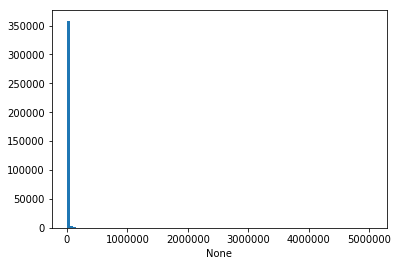

Histograma:


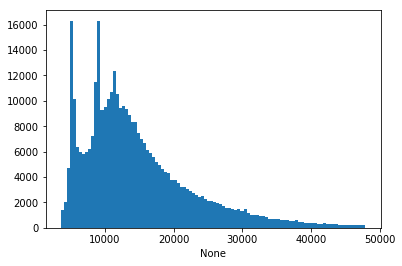

Histograma:


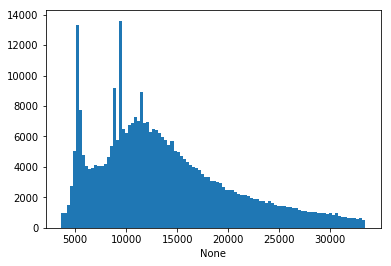

Histograma:


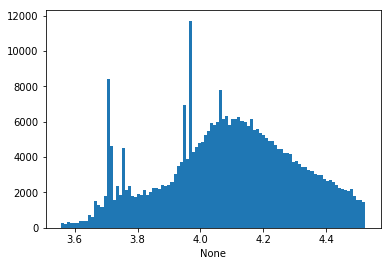

In [9]:
###################################
# ESTUDIO DE LA VARIABLE OBJETIVO #
###################################
var_objetivo = traindata['Poder_Adquisitivo']
var_objetivo_sin_outliers = traindata_without_outliers['Poder_Adquisitivo']
var_objetivo_sin_extreme_outliers = traindata_without_extreme_outliers['Poder_Adquisitivo']

#HISTOGRAMA ORIGINAL DEL PODER ADQUISITO
#Se aprecian outliers
mostrar_histograma(var_objetivo)

#HISTOGRAMA DEL PODER ADQUISITIVO ELIMINANDO SOLO EXTREME OUTLIERS
mostrar_histograma(var_objetivo_sin_extreme_outliers)

#HISTOGRAMA DEL PODER ADQUISITIVO ELIMINANDO OUTLIERS
mostrar_histograma(var_objetivo_sin_outliers)

#Normalizacion de la variable objetivo
var_objetivo_normalizada = transformacion_logaritmica(var_objetivo_sin_outliers)
mostrar_histograma(var_objetivo_normalizada)

#Desnormalizacion de la variable objetivo
#var_objetivo_desnormalizada = transformacion_exponencial(var_objetivo_normalizada)
#mostrar_histograma(var_objetivo_desnormalizada)

In [10]:
#############################################
# VALORES DEL PODER ADQUISITO MAS REPETIDOS #
#############################################

a = np.array(var_objetivo)
x = collections.Counter(a)

d = dict((k, v) for k, v in x.items() if v >= 1000)

print ('Valores mas repetidos:')
print (d)


Valores mas repetidos:
{8865.2000000000007: 3038, 5112.0: 3231, 9343.3299999999999: 7203, 5123.3900000000003: 1584, 5650.4700000000003: 2551, 11529.200000000001: 1864, 5163.2399999999998: 2924}


In [11]:
########################################
# HISTOGRAMAS POR BLOQUES DE VARIABLES #
########################################

histogramas_a_visualizar = [0, 0, 0 ,0, 0]

if (histogramas_a_visualizar[0]):
    mostrar_histograma_bloque('Imp_Cons')
    
if (histogramas_a_visualizar[1]):
    mostrar_histograma_bloque('Imp_Sal')
    
if (histogramas_a_visualizar[2]):   
    mostrar_histograma_bloque('Ind_Prod')
    
if (histogramas_a_visualizar[3]):   
    mostrar_histograma_bloque('Num_Oper')
                              
if (histogramas_a_visualizar[4]):                              
    mostrar_histograma_bloque('Socio_Demo')

Matriz de correlaciones de variables con correlacion superior a  0.8 :


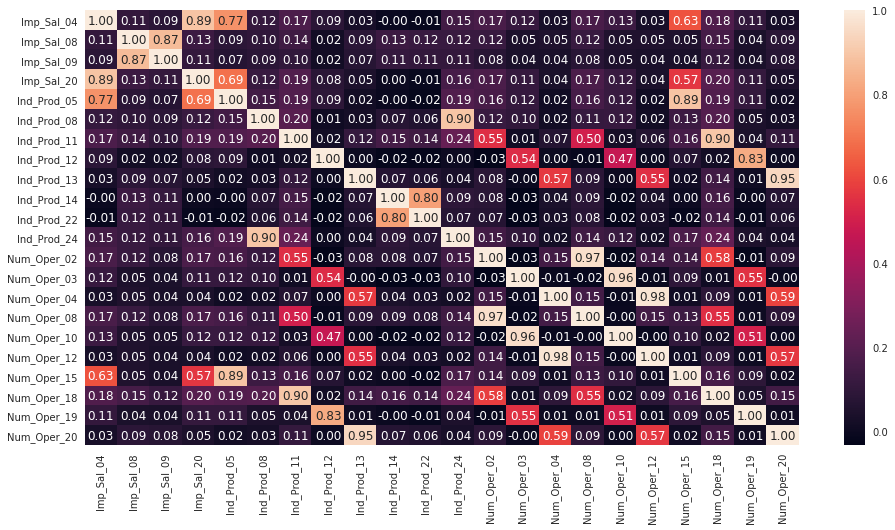

In [22]:
##########################
# VISUALIZACION DE DATOS #
##########################

# CONFIGURACION DE DATOS A VISUALIZAR
visualizar_rangos = 0
visualizar_histogramas = 0
visualizar_diagramas_cajas = 0
visualizar_matrices_correlacion = 1
visualizar_matrices_dispersion = 0

    
if (visualizar_rangos == 1):
    ###################
    # RANGOS OUTLIERS #
    ###################

    print ('Rango intercuartilico de variable objetivo:', iqr_calculate(traindata['Poder_Adquisitivo']))
    print ('Limites (inferior y superior) de los valores atipicos:', outliers_limits(traindata['Poder_Adquisitivo']))
    print ('Limites (inferior y superior) de los valores extremadamente atipicos:', extreme_outliers_limits(traindata['Poder_Adquisitivo']))

if (visualizar_histogramas == 1):
    ###############
    # HISTOGRAMAS #
    ###############

    mostrar_histograma(traindata['Poder_Adquisitivo'], 100, 'Poder_Adquisitivo Original')

    mostrar_histograma(traindata_without_extreme_outliers['Poder_Adquisitivo'], 50, 'Poder_Adquisitivo')
    mostrar_histograma(traindata_without_outliers['Poder_Adquisitivo'], 50, 'Poder_Adquisitivo')

if (visualizar_diagramas_cajas == 1):
    ######################
    # DIAGRAMAS DE CAJAS #
    ######################

    mostrar_diagrama_cajas(traindata['Poder_Adquisitivo'])
    mostrar_diagrama_cajas(traindata_without_extreme_outliers['Poder_Adquisitivo'])
    mostrar_diagrama_cajas(traindata_without_outliers['Poder_Adquisitivo'])

if (visualizar_matrices_correlacion == 1):
    #############################
    # MATRICES DE CORRELACIONES #
    #############################

    #mostrar_matriz_correlacion(traindata[numeric_cols])
    mostrar_matriz_correlacion_fuerte(traindata[numeric_cols], 0.8)
    #Variables con fuerte correlacion (>= 0.9):
    #Num_Oper_18 / Ind_Prod_11
    #Num_Oper_20 / Ind_Prod_13
    
    mostrar_matriz_correlacion_variables_fuertes(traindata[numeric_cols], 10)

    
if (visualizar_matrices_dispersion == 1):
    ##########################
    # MATRICES DE DISPERSION #
    ##########################
    
    #mostrar_matriz_dispersion(traindata[numeric_cols])
    #mostrar_matriz_dispersion_fuerte(traindata[numeric_cols], 0.8)
    mostrar_matriz_dispersion_variables_fuertes(traindata[numeric_cols], 5)

In [13]:
############################################
# MOSTRAR TODAS LAS MATRICES DE DISPERSION #
############################################

mostrar_todas_matrices_dispersion = 0 #Cuidado con activarlo: La ejecuion puede tardar un par de minutos

if (mostrar_todas_matrices_dispersion == 1):

    fig, axes = plt.subplots(nrows=31,ncols=2,figsize=(16,32),sharey=True)
    axes=axes.flatten()

    for i in range(len(axes)):
        axes[i].scatter(traindata_without_outliers[continuous_cols[i]],var_objetivo_sin_outliers)
        axes[i].set_xlabel('Poder_Adquisitivo')
        axes[i].set_ylabel(continuous_cols[i])
    plt.show()

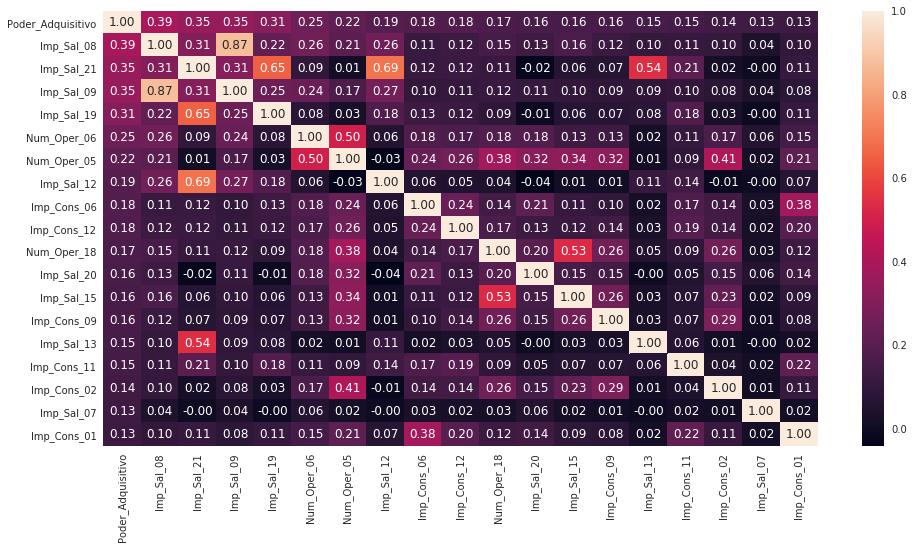

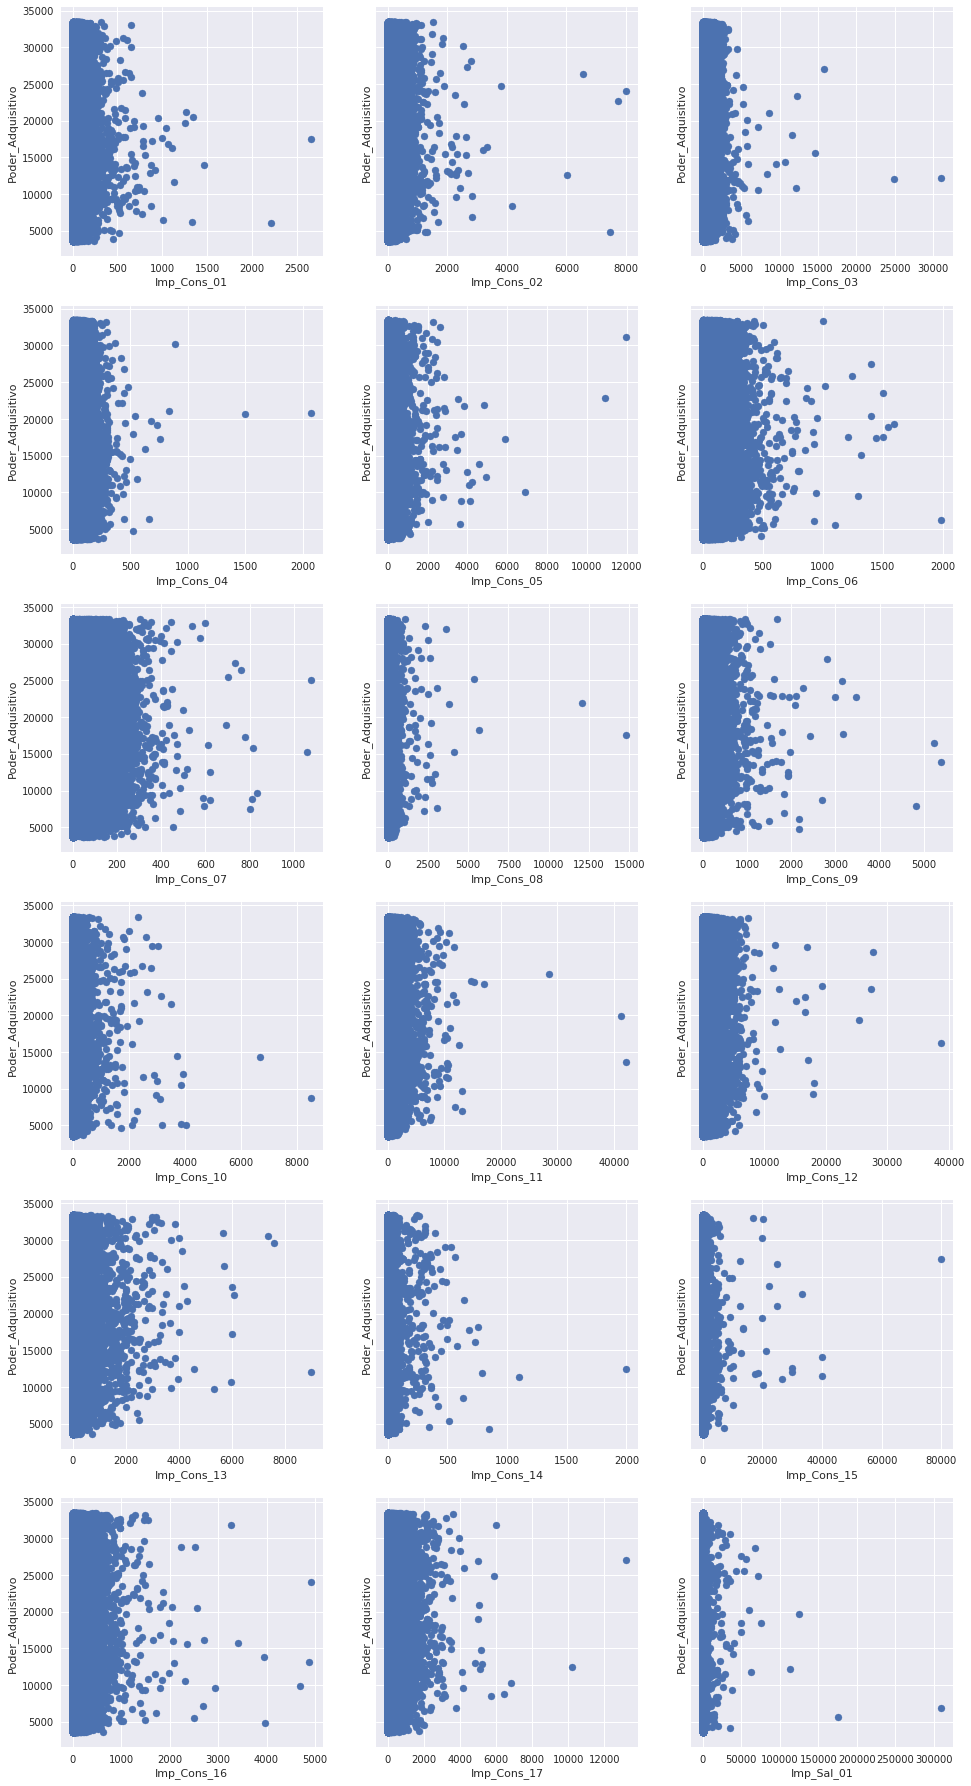

In [16]:
########################################################
# ANALISIS DE VARIABLES CONTINUAS DE MAYOR CORRELACION #
########################################################

analisis_variables_continuas = 1

if (analisis_variables_continuas == 1):

    #OBTENEMOS MATRIZ DE CORRELACION
    correlation=traindata[continuous_cols].corr() #Obtenemos la matriz de correlacion de las variables discretas
    aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #Ordenamos variables por su correlacion con PA
    selected_feats=aux[0:19].index #Seleccionamos las 19 de mayor correlacion (18 + PA)

    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
    plt.show()

    #MOSTRAMOS DIAGRAMAS DE DISPERSION
    selected_feats=selected_feats[1:] #Excluimos Poder Adquisitivo

    fig, axes = plt.subplots(nrows=6,ncols=3,figsize=(16,32),sharey=True)
    axes=axes.flatten()
    for i in range(len(axes)):
        axes[i].scatter(traindata_without_outliers[continuous_cols[i]], var_objetivo_sin_outliers)
        axes[i].set_xlabel(continuous_cols[i])
        axes[i].set_ylabel('Poder_Adquisitivo')
    plt.show()


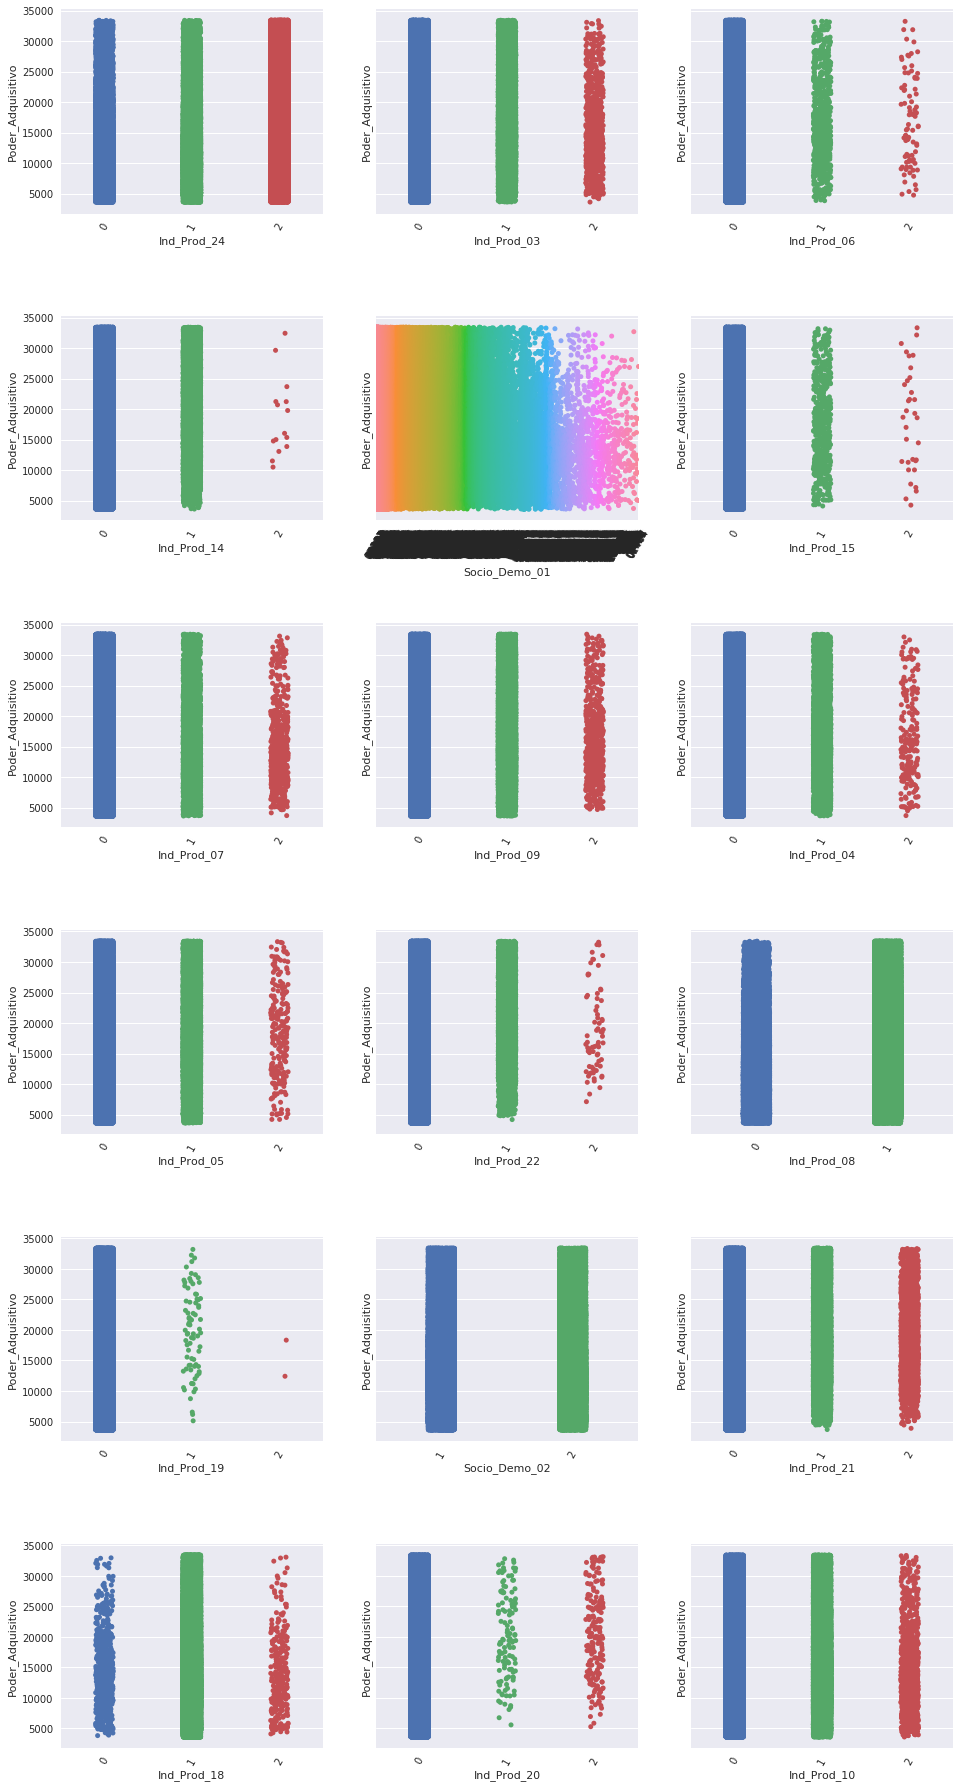

/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


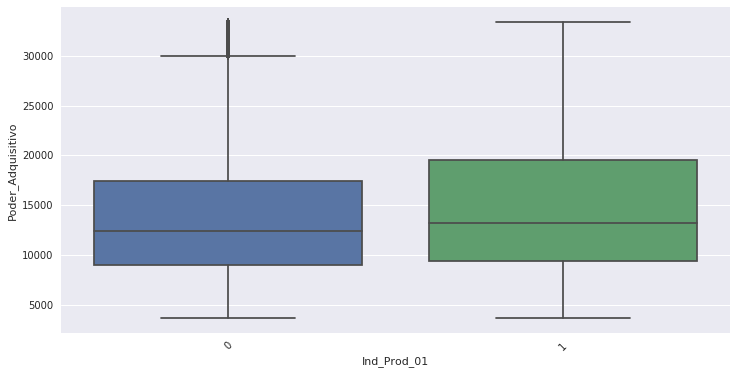

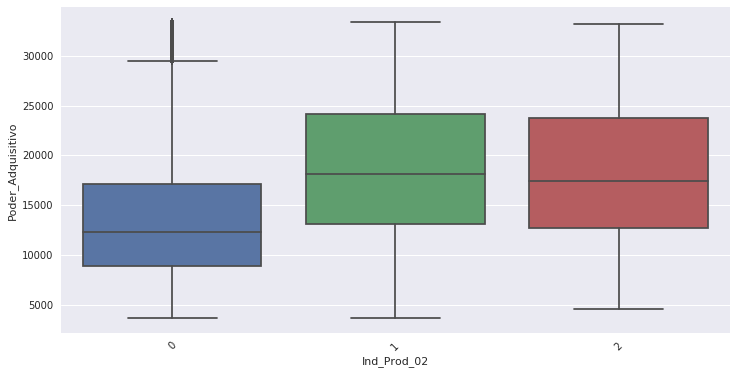

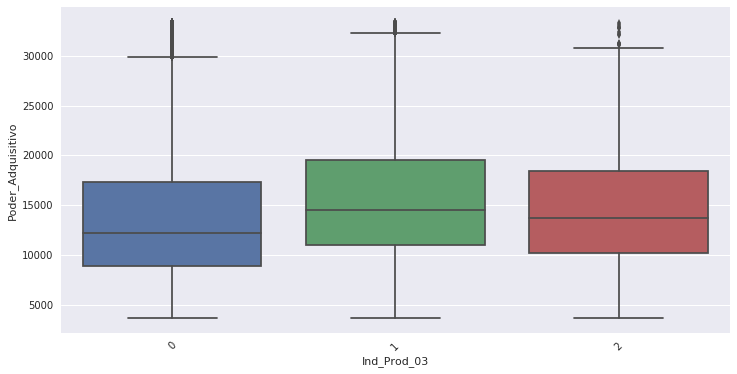

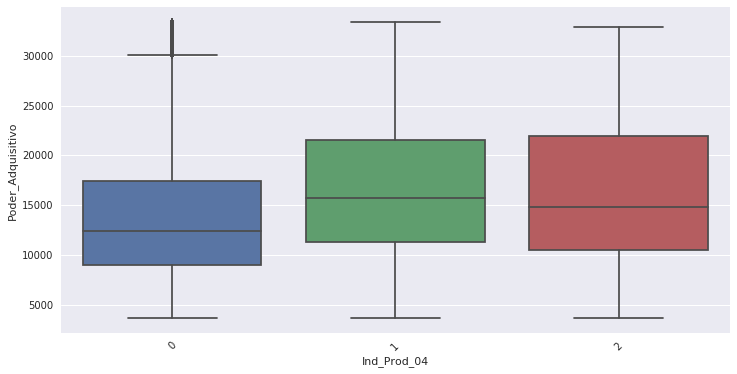

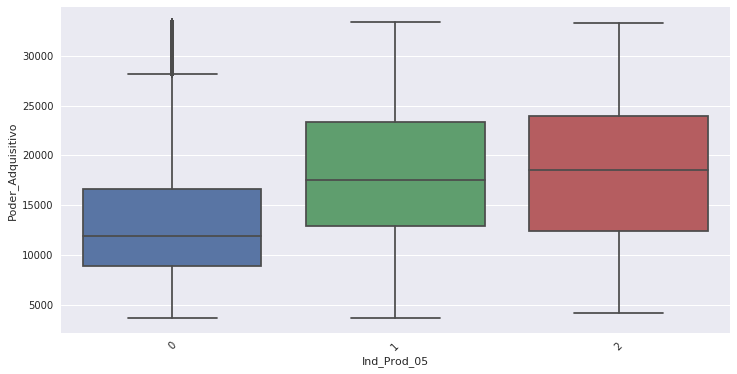

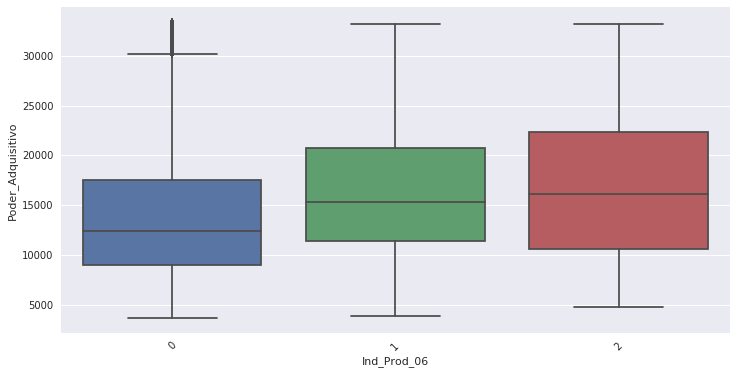

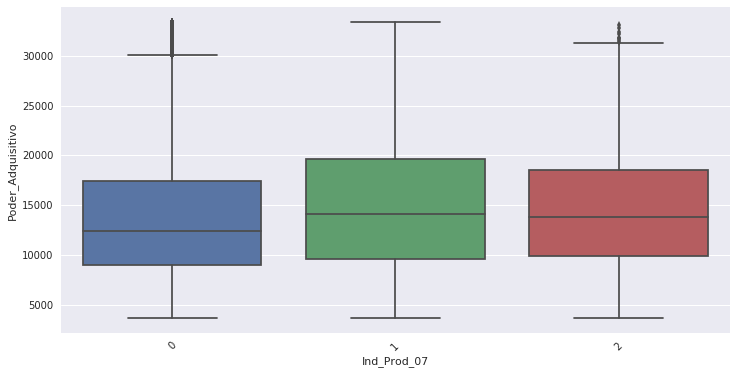

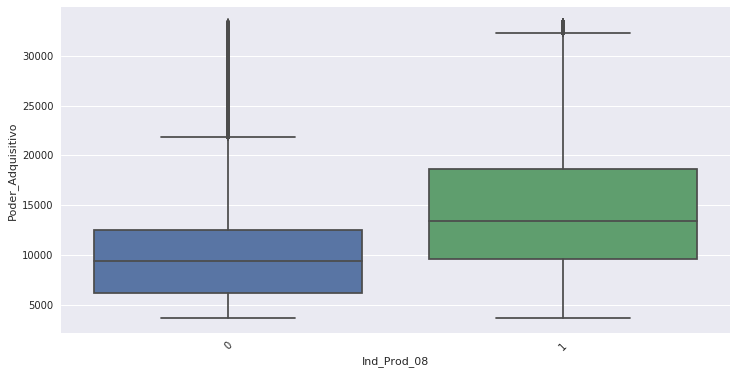

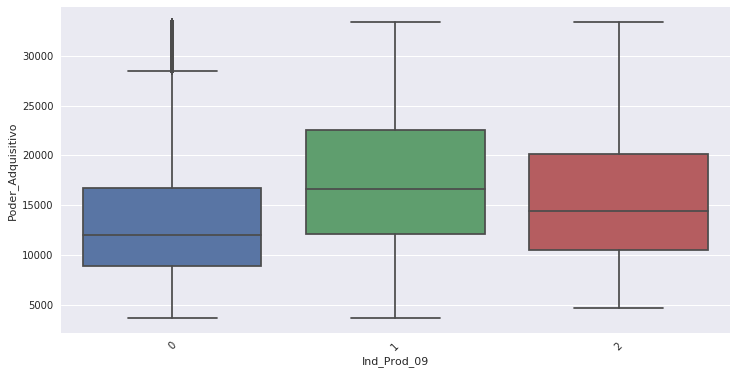

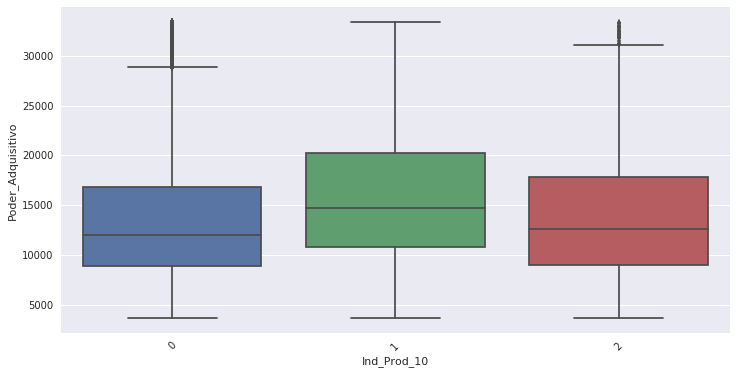

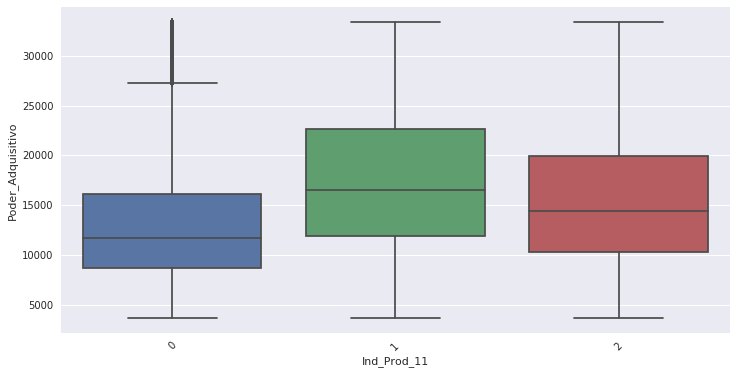

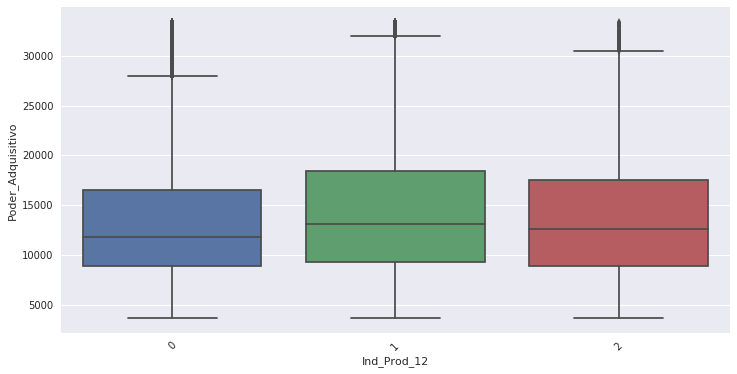

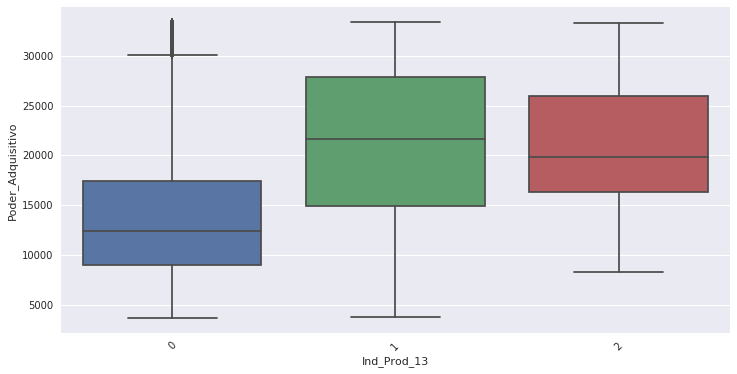

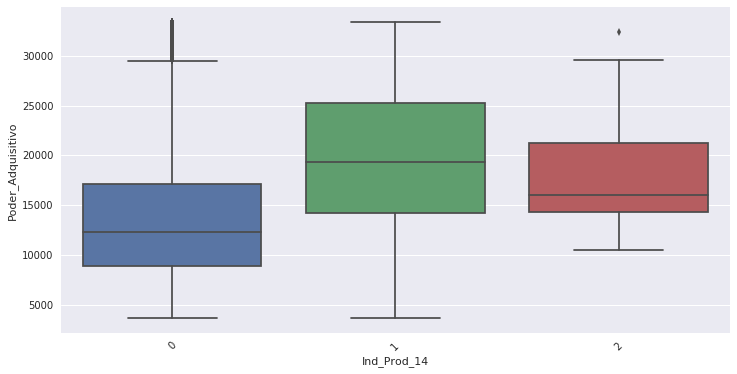

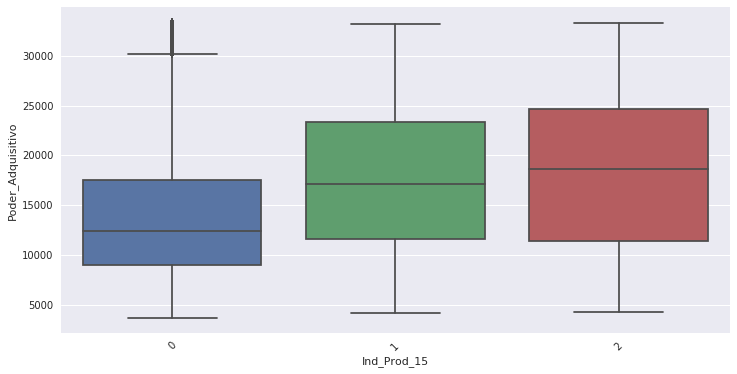

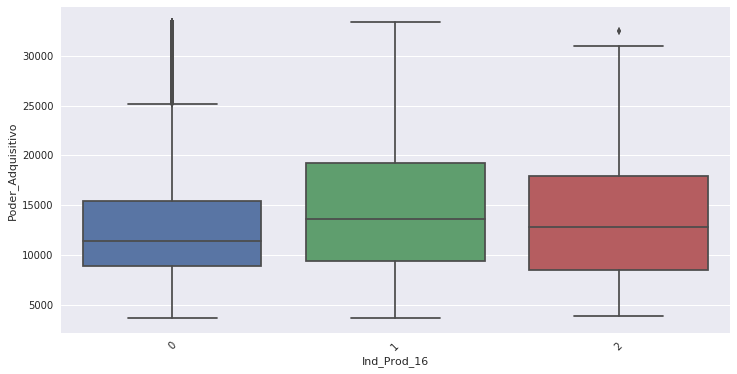

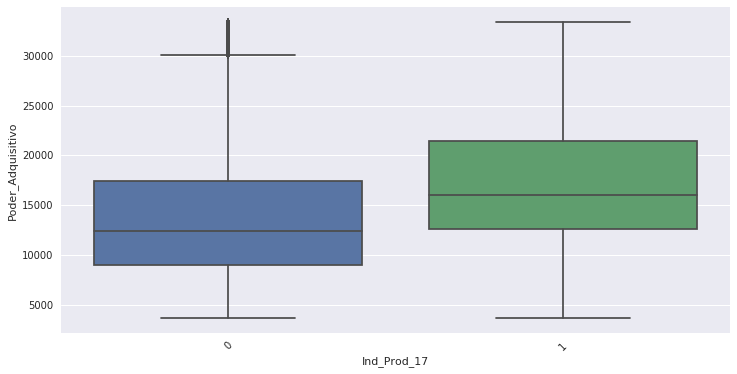

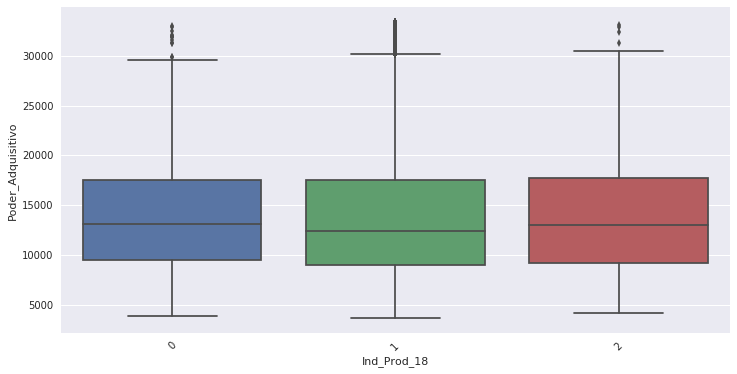

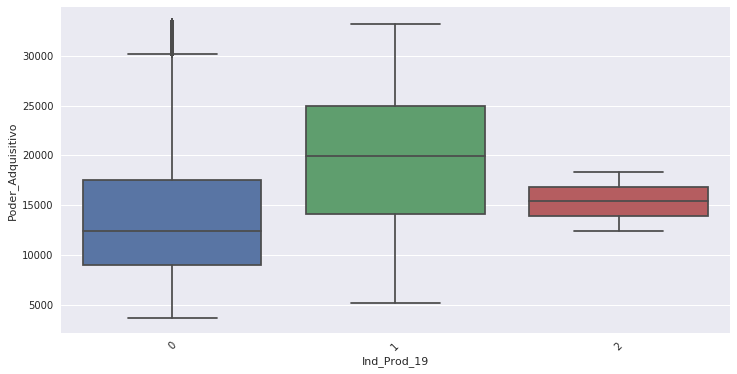

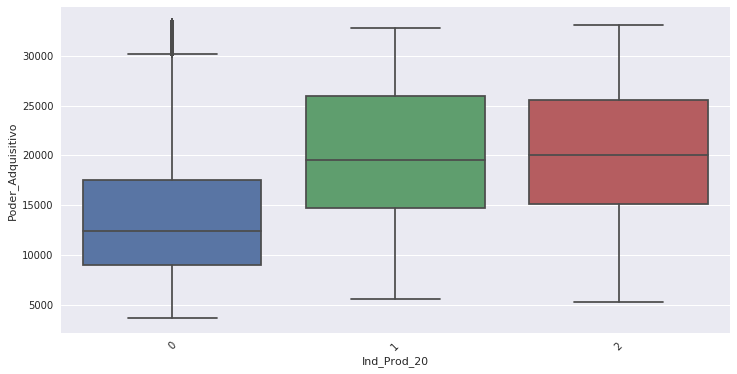

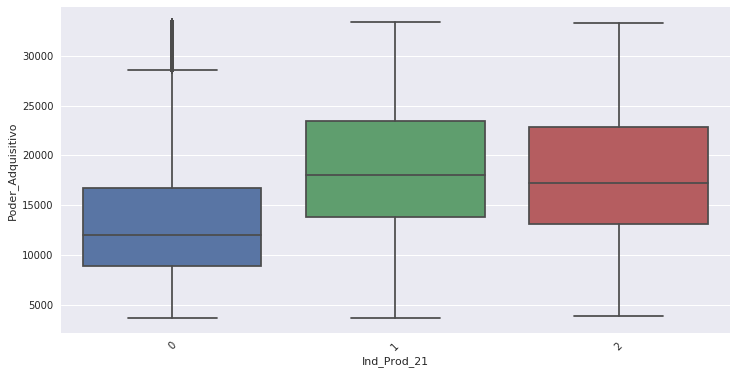

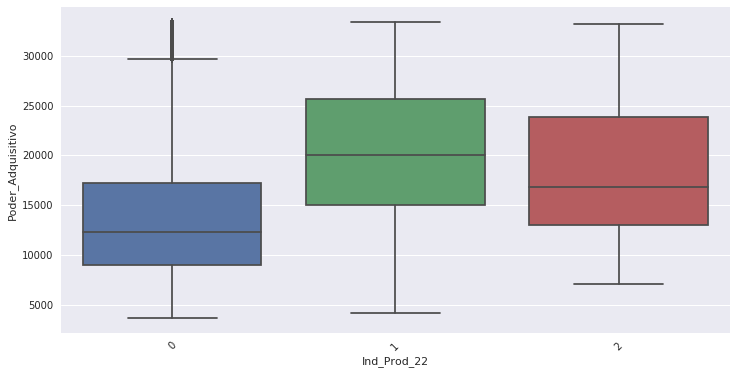

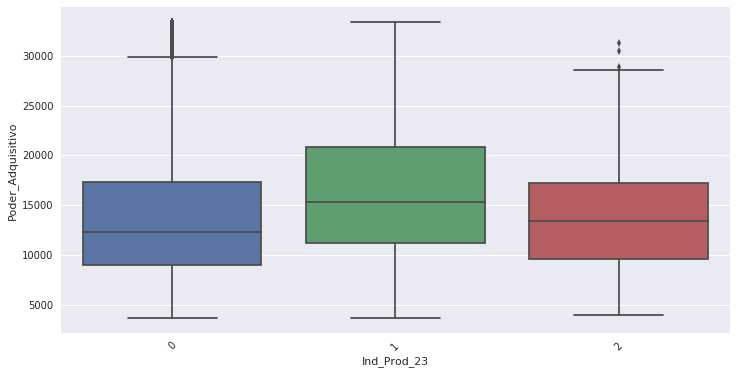

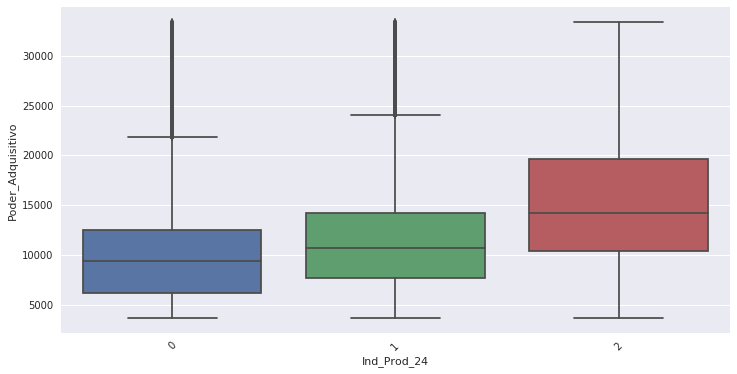

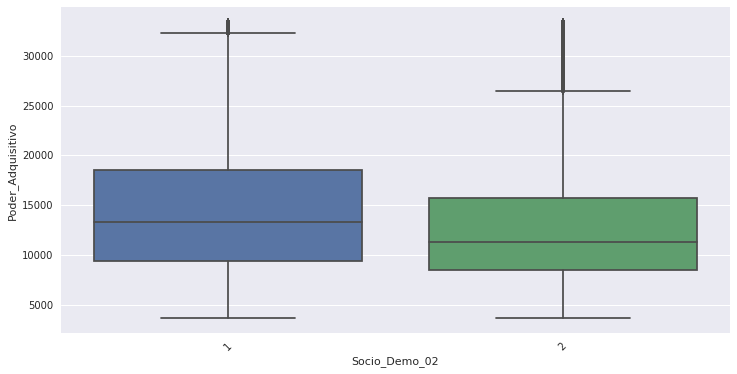

In [15]:
#####################################
# ANALISIS DE VARIABLES CATEGORICAS #
#####################################

analisis_variables_categoricas = 1

if (analisis_variables_categoricas == 1):
    
    visualizar_stripplots = 1
    visualizar_boxplots = 1
    
    ##############
    # STRIPPLOTS #
    ##############
    if (visualizar_stripplots == 1):
        selected_nominal_feats = np.random.choice(categorical_cols,18,replace=False)
        fig, axes = plt.subplots(nrows=6,ncols=3,figsize=(16,32),sharey=True)
        axes=axes.flatten()
        for i in range(len(axes)):
            sns.set()
            sns.stripplot(x=selected_nominal_feats[i], y='Poder_Adquisitivo', data=traindata_without_outliers,ax=axes[i],jitter=True)
            axes[i].set_xlabel(selected_nominal_feats[i])
            axes[i].xaxis.set_tick_params(rotation=60)
        plt.subplots_adjust(hspace = 0.5)
        plt.show()
    
    ############
    # BOXPLOTS #
    ############
    if (visualizar_boxplots == 1):
        
        for col in categorical_cols:

            if (col != 'Socio_Demo_01'): #Excluimos Socio_Demo_01 debido a su gran cantidad de categorias
                plt.figure(figsize = (12, 6))
                sns.boxplot(x = col, y = 'Poder_Adquisitivo',  data = traindata_without_outliers)
                xt = plt.xticks(rotation=45)